In [1]:
import pandas as pd
import bambi as bmb
import pingouin as pg
import joblib
from os import listdir
from os.path import join
from pathlib import Path
import numpy as np
import mne
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import aesara.tensor as at
import arviz as az

import matplotlib.patheffects as pe

import sys
sys.path.append('/mnt/obob/staff/fschmidt/cardiac_1_f')

from utils.pymc_utils import coefficients2pcorrs, aggregate_sign_feature
from utils.plot_utils import plot_ridge, plot_slope_corr, plot_bayes_linear_regression

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

sns.set_context('poster')
sns.set_style('ticks')

%matplotlib inline
#a seed for reproducibility
import random
random.seed(42069)


import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

heart_thresh, eye_thresh = 0.4, 0.8

indir = Path('/mnt/obob/staff/fschmidt/cardiac_1_f/data/data_sbg')
my_path_ending = f'*/*[[]0.1, 145[]]__eye_threshold_{eye_thresh}__heart_threshold_{heart_thresh}.dat'

all_files = sorted([str(sub_path) for sub_path in indir.glob(my_path_ending) if sub_path.is_file()])
print(len(all_files))


brms_kwargs = {'draws': 2000,
               'tune': 2000,
               'chains': 4,
               'target_accept': 0.9,}


/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


655


In [2]:
all_df, all_psd = [], []
for idx, file in enumerate(all_files):

    print(f'cur file {idx}/{len(all_files)}')

    cur_data = joblib.load(file)
    
    if 'ecg_scores' in cur_data.keys() and (cur_data['ecg_scores'] > heart_thresh).sum() > 0:
    
        def make_data_meg(cur_data, key):
            cur_psd = pd.DataFrame(cur_data['psd'])
            cur_psd['channel'] = np.arange(102)
            psd_melt = cur_psd.melt(id_vars='channel')
            psd_melt['Frequency (Hz)'] = psd_melt['variable'].replace(dict(zip(np.arange(len(cur_data['freqs'])), cur_data['freqs'])))
            psd_melt.drop(labels='variable', axis=1, inplace=True)
            psd_melt.columns = ['channel', key, 'Frequency (Hz)']
            return psd_melt

        mags_df = make_data_meg(cur_data['data_brain']['mag'], 'Magnetometers (ECG removed)')
        mags_heart_df = make_data_meg(cur_data['data_heart']['mag'], 'ECG Component Magnetometers')
        mags_no_ica_df = make_data_meg(cur_data['data_no_ica']['mag'], 'Magnetometers (ECG present)')

        df_meg_cmb = mags_df.merge(mags_heart_df, on=['channel', 'Frequency (Hz)'])
        df_meg_cmb = df_meg_cmb.merge(mags_no_ica_df, on=['channel', 'Frequency (Hz)'])                    
        df_ecg = pd.DataFrame({'ECG Electrode' : cur_data['data_heart']['ecg']['psd'][0,:],
                               'Frequency (Hz)': cur_data['data_heart']['ecg']['freqs'],
                              })
        
        df_psd = df_meg_cmb.merge(df_ecg, on='Frequency (Hz)')
        df_psd['subject_id'] = cur_data['subject_id']
        df_psd['age'] = float(cur_data['age'])
        all_psd.append(df_psd)
            

        all_df.append(pd.DataFrame({'heart_slope_mag': cur_data['data_heart']['mag']['exponents'],
                                    'brain_slope': cur_data['data_brain']['mag']['exponents'],
                                    'brain_no_ica': cur_data['data_no_ica']['mag']['exponents'],
                                    'heart_slope': cur_data['data_heart']['ecg']['exponents'][0],
                                    'heart_slope_avg': cur_data['data_heart']['mag']['aps_mag']['Exponent'].mean(),
                                    'brain_slope_avg': cur_data['data_brain']['mag']['aps_mag']['Exponent'].mean(),
                                    'no_ica_slope_avg': cur_data['data_no_ica']['mag']['aps_mag']['Exponent'].mean(),
                                    'channel': np.arange(102),
                                    'n_components': (cur_data['ecg_scores'] > heart_thresh).sum(),
                                    'explained_variance_ratio': cur_data['explained_variance_ecg']['mag'],
                                    'subject_id': cur_data['subject_id'],
                                    'age': float(cur_data['age'])}))
df_cmb = pd.concat(all_df)

df_cmb_psd = pd.concat(all_psd)

cur file 0/655
cur file 1/655
cur file 2/655
cur file 3/655
cur file 4/655
cur file 5/655
cur file 6/655
cur file 7/655
cur file 8/655
cur file 9/655
cur file 10/655
cur file 11/655
cur file 12/655
cur file 13/655
cur file 14/655
cur file 15/655
cur file 16/655
cur file 17/655
cur file 18/655
cur file 19/655
cur file 20/655
cur file 21/655
cur file 22/655
cur file 23/655
cur file 24/655
cur file 25/655
cur file 26/655
cur file 27/655
cur file 28/655
cur file 29/655
cur file 30/655
cur file 31/655
cur file 32/655
cur file 33/655
cur file 34/655
cur file 35/655
cur file 36/655
cur file 37/655
cur file 38/655
cur file 39/655
cur file 40/655
cur file 41/655
cur file 42/655
cur file 43/655
cur file 44/655
cur file 45/655
cur file 46/655
cur file 47/655
cur file 48/655
cur file 49/655
cur file 50/655
cur file 51/655
cur file 52/655
cur file 53/655
cur file 54/655
cur file 55/655
cur file 56/655
cur file 57/655
cur file 58/655
cur file 59/655
cur file 60/655
cur file 61/655
cur file 62/655
cu

In [3]:
avg_psd = df_cmb_psd.groupby(['Frequency (Hz)', 'channel']).mean().reset_index()

df_cmb.to_csv('../data/sbg_1_f_dataframe_1_145.csv')

cur_df_cmb = df_cmb.query('channel == 0')
df_cmb_psd.to_csv('../data/sbg_1_f_dataframe_1_145_psd.csv')

In [4]:
#get basic demographics
cur_df_cmb = df_cmb.query('channel == 0')

dem_dict = {'n_subj': len(cur_df_cmb['subject_id'].unique()),
            'mean_age': cur_df_cmb['age'].mean(),
            'std_age': cur_df_cmb['age'].std(),
            'min': cur_df_cmb['age'].min(),
            'max': cur_df_cmb['age'].max(),}

print(dem_dict)

{'n_subj': 655, 'mean_age': 32.77709923664122, 'std_age': 14.798207206511007, 'min': 18.0, 'max': 73.0}


In [5]:
(cur_df_cmb['age'] < 30).sum()

423

In [6]:
sbg_palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True) #for power spectra

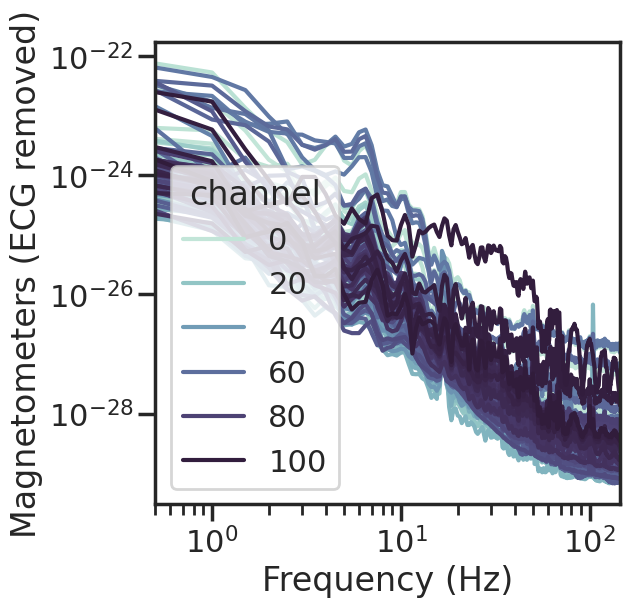

In [16]:
my_freqs = '_1_145'

fig, ax = plt.subplots()
sns.lineplot(x='Frequency (Hz)', y='Magnetometers (ECG removed)',
             hue="channel", palette=sbg_palette,
             data=avg_psd, ax=ax)
fig.set_size_inches(6,6)
plt.xlim(0.5, 145)
plt.xscale('log')
plt.yscale('log')

fig.savefig(f'../results/mags_ga_ecg_removed_sbg.svg')

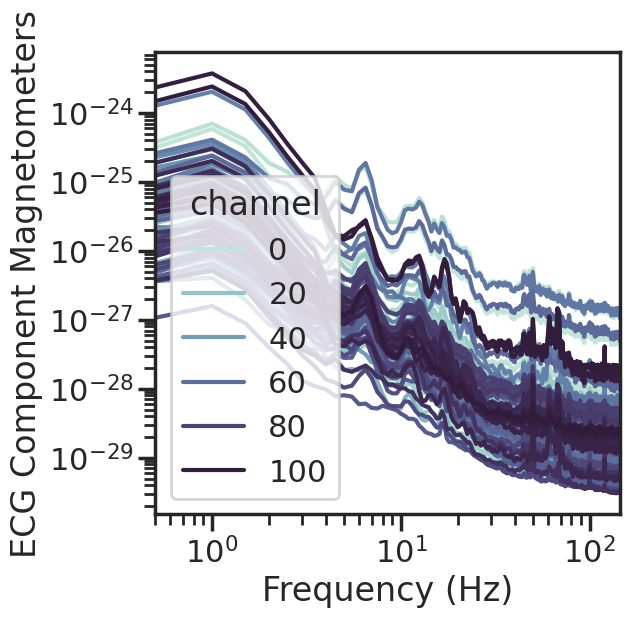

In [17]:
fig, ax = plt.subplots()
sns.lineplot(x='Frequency (Hz)', y='ECG Component Magnetometers',
             hue="channel", palette=sbg_palette,
             data=avg_psd, ax=ax)
fig.set_size_inches(6,6)
plt.xlim(0.5, 145)
plt.xscale('log')
plt.yscale('log')
fig.savefig(f'../results/mags_ga_ecg_comp_sbg.svg')

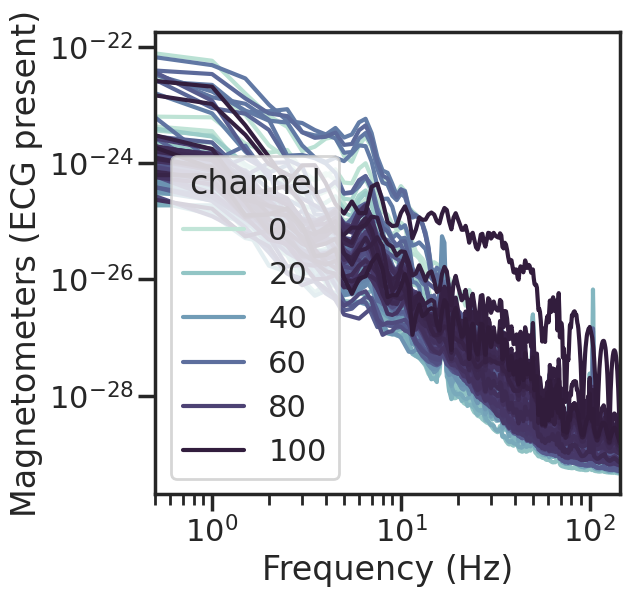

In [18]:
fig, ax = plt.subplots()
sns.lineplot(x='Frequency (Hz)', y='Magnetometers (ECG present)',
             hue="channel", palette=sbg_palette,
             data=avg_psd, ax=ax)
fig.set_size_inches(6,6)
plt.xlim(0.5, 145)
plt.xscale('log')
plt.yscale('log')
fig.savefig(f'../results/mags_ga_ecg_present_sbg.svg')

In [8]:
def plot_slope_age_corr(df, key, x, y, color):
    corr = pg.corr(df['age'], df[key])
    print(corr)
    g = sns.lmplot(data=df, x='age', y=key, line_kws={'color': color},
                   scatter_kws={"s": 40, 'color': '#888888', 'alpha': 0.25})

    r = round(float(corr['r']), 2)
    p = round(float(corr['p-val']), 3)

    if p == 0.0:
        p = 'p < 0.001'
    else:
        p = f'p = {p}'

    plt.annotate(text=f'r = {r}', xy=(x, y))
    plt.annotate(text=p, xy=(x, y - 0.2))

    g.set_xlabels('age (years)')
    g.set_ylabels('1/f slope')
    g.ax.figure.savefig(f'../results/corr_sbg_{key}_{my_freqs}.svg', )



def baycor(data):
    with pm.Model() as correlation_model:

        # set some more or less informative priors here
        mu_exp = pm.Normal('mu_exp', mu=0, sigma=1.) #
        mu_age = pm.Normal('mu_age', mu=40, sigma=10.) # age is coded in groups here: think about whether a normal really makes sense here

        #prior on correlation
        chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=4.0, 
                sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True)

        #stack data together
        mu = at.stack((mu_exp, mu_age), axis=1)
    
        #observed data
        y = pm.MvNormal('y', mu=mu, chol=chol, observed=data)

        trace = pm.sample()
    return trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, age, no_ica_slope_avg_sigma, no_ica_slope_avg_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 56 seconds.


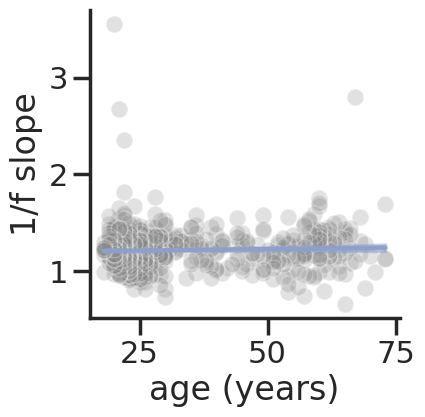

In [19]:
#%% slope ecg not rejected
md_no_ica = bmb.Model(data=cur_df_cmb, 
                    formula='no_ica_slope_avg ~ 1 + age', 
                    dropna=True,
                    family='t'
                    )
md_no_ica.build()

mdf_no_ica = md_no_ica.fit(**brms_kwargs)
sum_no_ica = az.summary(mdf_no_ica)
md_no_ica.predict(mdf_no_ica) # needed for plotting
md_no_ica.predict(mdf_no_ica, kind='pps') #do posterior pred checks


g_ecg_present = plot_bayes_linear_regression(df=cur_df_cmb, fitted=mdf_no_ica, 
                                          line_color='#8da0cb',
                                          x_key='age', y_key='no_ica_slope_avg',
                                          add_ppm=True)
g_ecg_present.figure.set_size_inches(4,4)
g_ecg_present.set_xlabel('age (years)')
g_ecg_present.set_ylabel('1/f slope')
sns.despine()
g_ecg_present.figure.savefig(f'../results/pred_no_ica_avg_{my_freqs}_sbg.svg')

In [22]:
sum_no_ica

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.199,0.015,1.170,1.227,0.000,0.000,7338.0,6114.0,1.0
age,0.001,0.000,-0.000,0.001,0.000,0.000,7184.0,5927.0,1.0
no_ica_slope_avg_sigma,0.138,0.006,0.127,0.149,0.000,0.000,6035.0,5674.0,1.0
no_ica_slope_avg_nu,4.523,0.707,3.318,5.864,0.009,0.007,5798.0,5659.0,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, age, heart_slope_avg_sigma, heart_slope_avg_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 68 seconds.


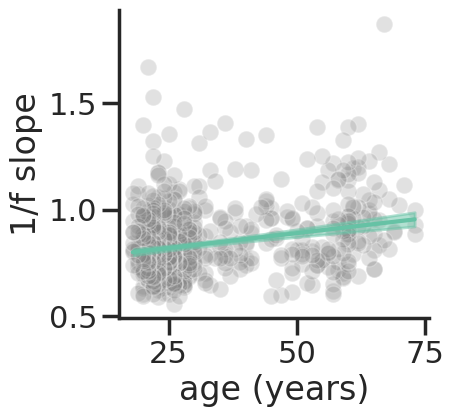

In [21]:
#%% ecg component only
md_comp_ecg = bmb.Model(data=cur_df_cmb, 
                    formula='heart_slope_avg ~ 1 + age', 
                    dropna=True,
                    family='t')
md_comp_ecg.build()

mdf_comp_ecg = md_comp_ecg.fit(**brms_kwargs)
sum_comp_ecg = az.summary(mdf_comp_ecg)

md_comp_ecg.predict(mdf_comp_ecg) # needed for plotting
md_comp_ecg.predict(mdf_comp_ecg, kind='pps') #do posterior pred checks

#az.plot_ppc(mdf_comp_ecg)

g_ecg_comp = plot_bayes_linear_regression(df=cur_df_cmb, fitted=mdf_comp_ecg, 
                                          line_color='#66c2a5',
                                          x_key='age', y_key='heart_slope_avg',
                                          add_ppm=True)
g_ecg_comp.figure.set_size_inches(4,4)
g_ecg_comp.set_xlabel('age (years)')
g_ecg_comp.set_ylabel('1/f slope')
sns.despine()
g_ecg_comp.figure.savefig(f'../results/pred_heart_slope_avg_{my_freqs}_sbg.svg', )

In [23]:
sum_comp_ecg

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.750,0.014,0.723,0.776,0.000,0.000,6910.0,6127.0,1.0
age,0.003,0.000,0.002,0.004,0.000,0.000,6732.0,5738.0,1.0
heart_slope_avg_sigma,0.125,0.006,0.114,0.136,0.000,0.000,5136.0,5633.0,1.0
heart_slope_avg_nu,5.406,1.121,3.621,7.545,0.016,0.011,5068.0,5047.0,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, age, brain_slope_avg_sigma, brain_slope_avg_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 70 seconds.


-0.0010541038896299533


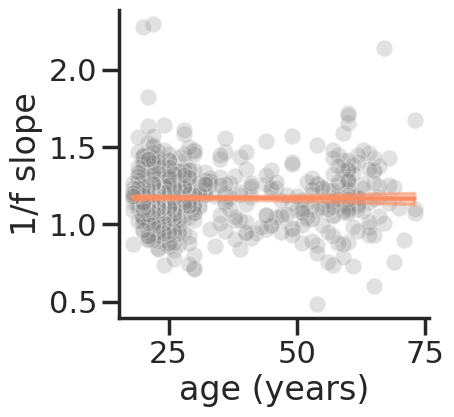

In [24]:
#%% slope ecg rejected
md_ica = bmb.Model(data=cur_df_cmb, 
                    formula='brain_slope_avg ~ 1 + age', 
                    dropna=True,
                    family='t'
                    )
md_ica.build()

mdf_ica = md_ica.fit(**brms_kwargs)
sum_ica = az.summary(mdf_ica, round_to=None)

md_ica.predict(mdf_ica) # needed for plotting
md_ica.predict(mdf_ica, kind='pps') #do posterior pred checks

#az.plot_ppc(mdf_ica)
#%%
g_ica_comp = plot_bayes_linear_regression(df=cur_df_cmb, fitted=mdf_ica, 
                                          line_color='#fc8d62',
                                          x_key='age', y_key='brain_slope_avg',
                                          add_ppm=True)
g_ica_comp.figure.set_size_inches(4,4)
g_ica_comp.set_xlabel('age (years)')
g_ica_comp.set_ylabel('1/f slope')
sns.despine()
g_ica_comp.figure.savefig(f'../results/pred_brain_slope_avg_{my_freqs}_sbg.svg', )

In [25]:
sum_ica

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.178,0.017,1.146,1.209,0.000,0.000,6751.0,5345.0,1.0
age,-0.000,0.000,-0.001,0.001,0.000,0.000,6603.0,5594.0,1.0
brain_slope_avg_sigma,0.151,0.007,0.139,0.164,0.000,0.000,5881.0,5768.0,1.0
brain_slope_avg_nu,6.256,1.378,3.998,8.910,0.019,0.014,5769.0,5390.0,1.0


In [27]:
#normalized betas for comparison
cur_df_z = zscore(cur_df_cmb[['heart_slope_avg', 'brain_slope_avg', 'no_ica_slope_avg', 'age']], axis=0)


mdf_comp_ecg_z = bmb.Model(data=cur_df_z, 
                    formula='heart_slope_avg ~ 1 + age', 
                    dropna=True,
                    family='t').fit(**brms_kwargs)

mdf_no_ica_z = bmb.Model(data=cur_df_z, 
                    formula='no_ica_slope_avg ~ 1 + age', 
                    dropna=True,
                    family='t').fit(**brms_kwargs)

mdf_ica_z = bmb.Model(data=cur_df_z, 
                    formula='brain_slope_avg ~ 1 + age', 
                    dropna=True,
                    family='t').fit(**brms_kwargs)

#%% add standardized betas as stats
sum_no_ica_z = az.summary(mdf_no_ica_z)
#%%
sum_ica_z = az.summary(mdf_ica_z)
#%%
sum_ecg_z = az.summary(mdf_comp_ecg_z)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, age, heart_slope_avg_sigma, heart_slope_avg_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 53 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, age, no_ica_slope_avg_sigma, no_ica_slope_avg_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, age, brain_slope_avg_sigma, brain_slope_avg_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 42 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.105,0.036,-0.173,-0.038,0.000,0.000,6070.0,5857.0,1.0
age,0.249,0.035,0.186,0.317,0.000,0.000,6677.0,6130.0,1.0
heart_slope_avg_sigma,0.750,0.035,0.684,0.815,0.000,0.000,5159.0,5481.0,1.0
heart_slope_avg_nu,5.390,1.106,3.416,7.362,0.016,0.012,4922.0,4547.0,1.0


In [58]:
sum_ica_z

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.027,0.036,-0.093,0.039,0.000,0.000,6652.0,5704.0,1.0
age,-0.012,0.037,-0.080,0.058,0.000,0.000,6631.0,5454.0,1.0
brain_slope_avg_sigma,0.804,0.036,0.736,0.873,0.000,0.000,6222.0,5203.0,1.0
brain_slope_avg_nu,6.270,1.416,3.959,8.896,0.019,0.014,6492.0,5485.0,1.0


/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

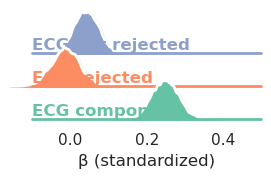

In [30]:
df2density = pd.DataFrame({'ECG not rejected': mdf_no_ica_z.posterior['age'].to_numpy().flatten(),
              'ECG rejected': mdf_ica_z.posterior['age'].to_numpy().flatten(),
              'ECG component': mdf_comp_ecg_z.posterior['age'].to_numpy().flatten(),
             })

df2density_tidy = df2density.melt()

#%%
(df2density['ECG not rejected'] > df2density['ECG rejected']).mean()


#%%
sns.set_style('ticks')
sns.set_context('poster')

my_colors = ['#8da0cb', '#fc8d62', '#66c2a5']

g = plot_ridge(df2density_tidy, 'variable', 'value', pal=my_colors, aspect=5, xlim=(-0.1, .5), height=0.6)
g.set_xlabels('β (standardized)')
g.figure.savefig('../results/beta_comp_sbg.svg')

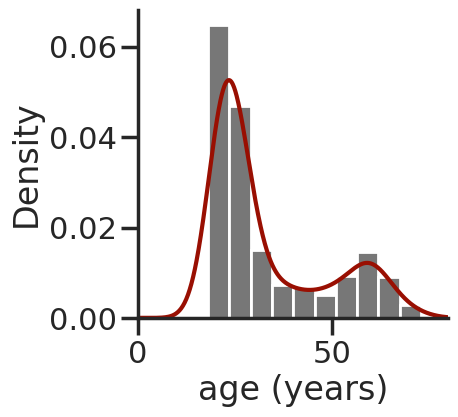

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))
cur_df_cmb['age'].plot(kind='hist', color='#777777', density=True)
cur_df_cmb['age'].plot(kind='kde', color='#990F02')
ax.set_xlabel('age (years)')
ax.set_ylabel('Density')
ax.set_xlim(0, 80)
sns.despine()
ax.figure.savefig('../results/age_dist_sbg.svg')

In [51]:
#fuck bimodal distributions...
#need to make the priors more informative to improve sampling
K = 2

with pm.Model() as multi_regression:

    # set some more or less informativ priors
    b0 = pm.Normal("Intercept", 0, 30, shape=K)
    b1 = pm.Normal('heart_slope_avg', 0, 20, shape=K)
    b2 = pm.Normal('brain_slope_avg', 0, 20, shape=K)
    sigma = pm.HalfCauchy("sigma", beta=1, shape=K)
    phi = pm.Dirichlet('phi', np.array([1.0]*K), initval=np.ones(K)/K)

    #regression
    mu = (b0 + b1 * cur_df_cmb['heart_slope_avg'].values[:, None] 
             + b2 * cur_df_cmb['brain_slope_avg'].values[:, None])

    # likelihood
    y = pm.NormalMixture('age', mu=mu, sigma=sigma, w=phi,
                            observed=cur_df_cmb['age'].values)

    mdf = pm.sample(**brms_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, heart_slope_avg, brain_slope_avg, sigma, phi]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 396 seconds.


<AxesSubplot:xlabel='age / age'>

/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


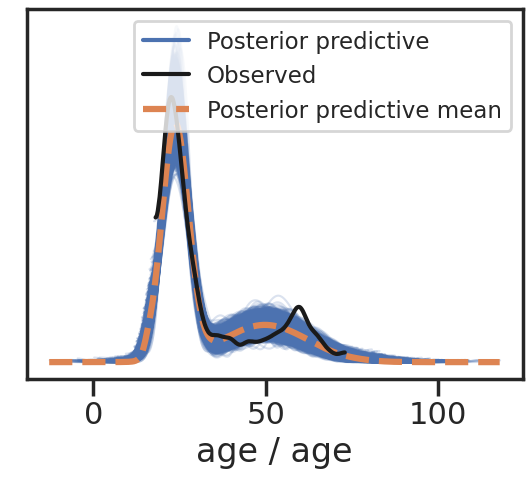

In [52]:
with multi_regression:
   pm.sample_posterior_predictive(mdf,  extend_inferencedata=True)

az.plot_ppc(mdf)

In [55]:
az.summary(mdf)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[0],31.812,6.942,21.473,44.311,2.144,1.560,11.0,2954.0,1.27
Intercept[1],26.990,5.431,21.491,40.021,2.164,1.608,9.0,29.0,1.41
heart_slope_avg[0],12.511,7.757,-0.877,23.603,3.285,2.457,7.0,30.0,1.52
heart_slope_avg[1],4.965,6.920,-1.617,19.720,3.222,2.441,7.0,31.0,1.52
brain_slope_avg[0],0.671,3.808,-5.603,8.786,0.621,0.443,42.0,2578.0,1.06
brain_slope_avg[1],-0.818,2.543,-4.287,5.435,0.654,0.472,28.0,29.0,1.27
sigma[0],9.612,3.803,2.877,13.017,1.869,1.427,7.0,28.0,1.53
sigma[1],5.282,3.748,2.777,12.328,1.859,1.422,7.0,29.0,1.53
phi[0],0.418,0.144,0.298,0.692,0.071,0.055,7.0,27.0,1.53
phi[1],0.582,0.144,0.308,0.702,0.071,0.054,7.0,27.0,1.53


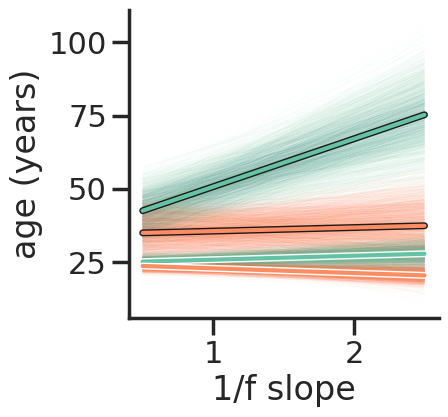

In [50]:
# %% plot complete posterior distribution
slope_brain = mdf.posterior['brain_slope_avg'].stack(draws=("chain", "draw")).values
slope_heart = mdf.posterior['heart_slope_avg'].stack(draws=("chain", "draw")).values
intercept = mdf.posterior["Intercept"].stack(draws=("chain", "draw")).values

sns.set_context('poster')
sns.set_style('ticks')

x_range = np.array([0.5, 2.5])
#np.array([df_heart_brain['heart_slope_mag'].min(), df_heart_brain['heart_slope_mag'].max()])
#brain_min_max = np.array([df_heart_brain['brain_slope'].min(), df_heart_brain['brain_slope'].max()])

fig = plt.figure()

#cluster a
plt.plot(x_range, intercept[0,:].mean() + slope_heart[0,:].mean() * x_range, color='#66c2a5',
         path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
plt.plot(x_range, intercept[0,:] + slope_heart[0,:] * x_range[:, None], 
          color='#66c2a5', zorder=1, lw=0.1, alpha=0.1)

#cluster b
plt.plot(x_range, intercept[1,:].mean() + slope_heart[1,:].mean() * x_range, color='#66c2a5',
         path_effects=[pe.Stroke(linewidth=5, foreground='w'), pe.Normal()])
plt.plot(x_range, intercept[1,:] + slope_heart[1,:] * x_range[:, None], 
          color='#66c2a5', zorder=1, lw=0.1, alpha=0.1)


plt.plot(x_range, intercept[0,:].mean() + slope_brain[0,:].mean() * x_range, color='#FC8D62',
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])
plt.plot(x_range, intercept[0,:] + slope_brain[0,:] * x_range[:, None], 
          color='#FC8D62', zorder=1, lw=0.1, alpha=0.1)


plt.plot(x_range, intercept[1,:].mean() + slope_brain[1,:].mean() * x_range, color='#FC8D62',
        path_effects=[pe.Stroke(linewidth=5, foreground='w'), pe.Normal()])
plt.plot(x_range, intercept[1,:] + slope_brain[1,:] * x_range[:, None], 
          color='#FC8D62', zorder=1, lw=0.1, alpha=0.1)

plt.xlabel("1/f slope")
plt.ylabel("age (years)");
sns.despine()

fig.set_size_inches(4,4)
fig.savefig('../results/age_pred_slope_ecg_vs_ica_all_sens_sbg.svg')

In [35]:
#visualize as partial correlation
import statsmodels.api as sm

predictor_vars = ['heart_slope_avg', 'brain_slope_avg']
samples = mdf.posterior
# x_matrix = common effects design matrix (excluding intercept/constant term)

x_matrix = cur_df_cmb[predictor_vars]

dm_statistics = {
    'r2_x': pd.Series(
        {
            x: sm.OLS(
                endog=x_matrix[x],
                exog=sm.add_constant(x_matrix.drop(x, axis=1))
                if "Intercept" in [i for i in mdf.posterior.data_vars] 
                else x_matrix.drop(x, axis=1),
            )
            .fit()
            .rsquared
            for x in list(x_matrix.columns)
        }
    ),
    'sigma_x': x_matrix.std(),
    'mean_x': x_matrix.mean(axis=0),
}

r2_x = dm_statistics['r2_x']
sd_x = dm_statistics['sigma_x']
r2_y = pd.Series([sm.OLS(endog=cur_df_cmb['age'],
                            exog=sm.add_constant(cur_df_cmb[[p for p in predictor_vars if p != x]])).fit().rsquared
                for x in predictor_vars], index=predictor_vars)
sd_y = cur_df_cmb['age'].std()

# compute the products to multiply each slope with to produce the partial correlations -> this might be problematic here due to my mixture stuff
slope_constant = (sd_x[predictor_vars] / sd_y) * ((1 - r2_x[predictor_vars]) / (1 - r2_y)) ** 0.5


heart_slope_pc = samples['heart_slope_avg'].stack(draws=("chain", "draw")).values 
brain_slope_pc = samples['brain_slope_avg'].stack(draws=("chain", "draw")).values 

df_pcorr = pd.DataFrame({'heart_slope_0': heart_slope_pc[0,:] * slope_constant['heart_slope_avg'],
                         'heart_slope_1': heart_slope_pc[1,:] * slope_constant['heart_slope_avg'],
                         'brain_slope_0': brain_slope_pc[0,:] * slope_constant['brain_slope_avg'],
                         'brain_slope_1': brain_slope_pc[1,:] * slope_constant['brain_slope_avg'],
                        })

tidy_pcorr = df_pcorr.melt()
tidy_pcorr.columns = ['predictors', 'partial correlation coefficient']

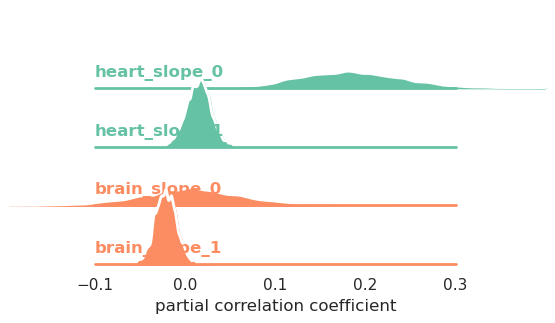

In [36]:
pal = ['#66c2a5', '#66c2a5', '#fc8d62', '#fc8d62']

g = plot_ridge(tidy_pcorr, 'predictors', 'partial correlation coefficient', pal=pal, 
height=0.9, aspect=5, xlim=(-0.1, .3))

g.figure.savefig('../results/partial_corr_heart_brain_age_all_sens_sbg.svg')